In [17]:
import pandas as pd
import numpy as np
import re

In [15]:
df_raw = pd.read_csv("/Users/yoran/Documents/Advanced_Simulation/Bangladesh_Assignment/data/raw/_roads.tsv", sep='\t')

df_bridges_raw = pd.read_excel('/Users/yoran/Documents/Advanced_Simulation/Bangladesh_Assignment/data/raw/BMMS_overview.xlsx')

/var/folders/04/yj5x8lbx49sc1jbf3gyzwr3h0000gn/T/ipykernel_43399/1161747910.py:1: DtypeWarning: Columns (571,574,577,580,583,586,589,592,595,598,601,604,607,610,613,616,619,622,625,628,631,634,637,640,643,646,649,652,655,658,661,664,667,670,673,676,679,682,685,688,691,694,697,700,703,706,709,712,715,718,721,724,727,730,733,736,739,742,745,748,751,754,757,760,763,766,769,772,775,778,781,784,787,790,793,796,799,802,805,808,811,814,817,820,823,826,829,832,835,838,841,844,847,850,853,856,859,862,865,868,871,874,877,880,883,886,889,892,895,898,901,904,907,910,913,916,919,922,925,928,931,934,937,940,943,946,949,952,955,958,961,964,967,970,973,976,979,982,985,988,991,994,997,1000,1003,1006,1009,1012,1015,1018,1021,1024,1027,1030,1033,1036,1039,1042,1045,1048,1051,1054,1057,1060,1063,1066,1069,1072,1075,1078,1081,1084,1087,1090,1093,1096,1099,1102,1105,1108,1111,1114,1117,1120,1123,1126,1129,1132,1135,1138,1141,1144,1147,1150,1153,1156,1159,1162,1165,1168,1171,1174,1177,1180,1183,1186,1189,119

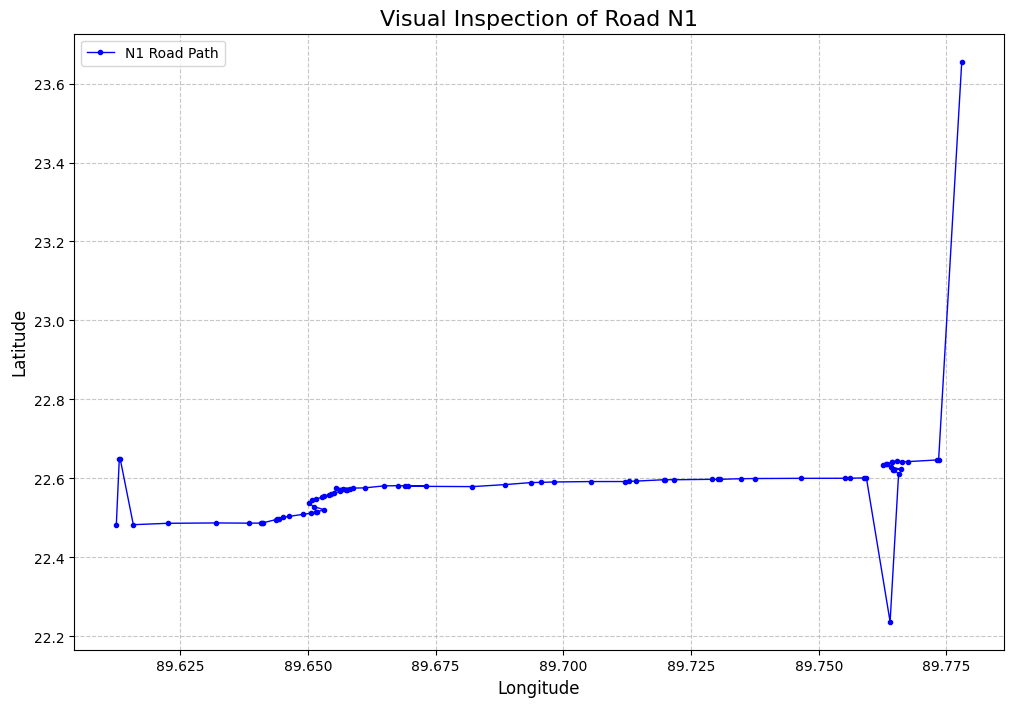

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = '/Users/yoran/Documents/Advanced_Simulation/Bangladesh_Assignment/data/raw/Roads_InfoAboutEachLRP.csv'
df = pd.read_csv(file_path, low_memory=False)

# Filter for Road N1
# We allow 'N1' or 'n1' just in case
road_n1 = df[df['road'].astype(str).str.upper() == 'Z7717'].copy()

# Sort (Crucial for the line to connect properly)
road_n1['chainage'] = pd.to_numeric(road_n1['chainage'], errors='coerce')
road_n1 = road_n1.sort_values(by='chainage')

# Plot
plt.figure(figsize=(12, 8))

# Plot the line (connects the dots) and the markers (dots)
plt.plot(road_n1['lon'], road_n1['lat'],
         linestyle='-',
         marker='o',
         markersize=3,
         linewidth=1,
         color='blue',
         label='N1 Road Path')

plt.title("Visual Inspection of Road N1", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()


# Show the plot
plt.show()

Identifying outliers...


/var/folders/04/yj5x8lbx49sc1jbf3gyzwr3h0000gn/T/ipykernel_43399/2521115204.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_df = df.groupby('road', group_keys=False).apply(get_outliers_only)


Found 273 outliers.
Outliers saved to: outliers_detected_and_corrected.csv
------------------------------
Processing roads (Cleaning & Interpolation)...


/var/folders/04/yj5x8lbx49sc1jbf3gyzwr3h0000gn/T/ipykernel_43399/2521115204.py:113: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df.groupby('road', group_keys=False).apply(clean_and_interpolate_road)


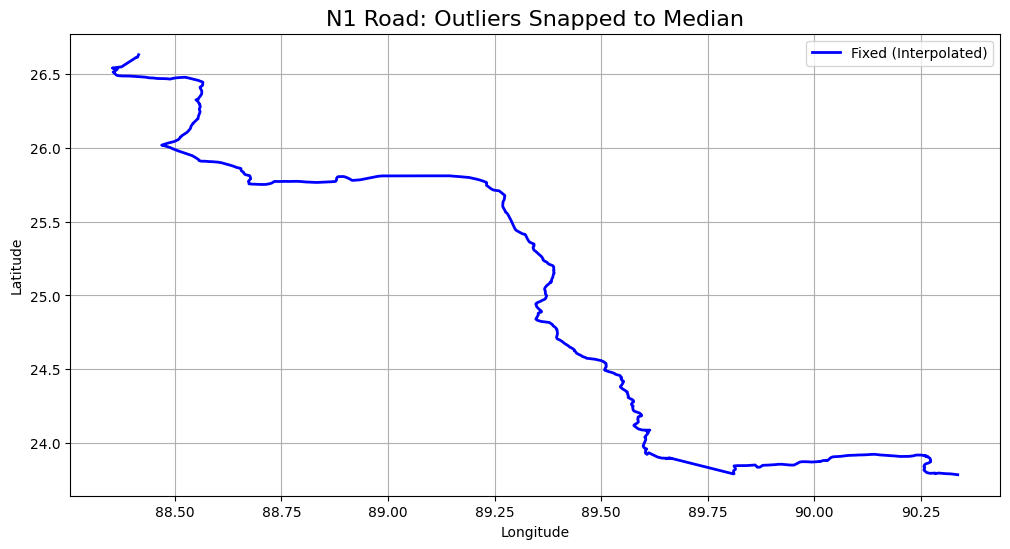

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


file_path = '/Users/yoran/Documents/Advanced_Simulation/Bangladesh_Assignment/data/raw/Roads_InfoAboutEachLRP.csv'
df = pd.read_csv(file_path, low_memory=False)

# Ensure numeric types
cols = ['chainage', 'lat', 'lon']
for c in cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')


def haversine_dist(lat1, lon1, lat2, lon2):
    """
    Calculates distance in KM between two lat/lon arrays using Haversine formula.
    """
    R = 6371.0  # Earth radius in kilometers

    # Convert degrees to radians
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    # The Math
    a = np.sin(dphi / 2)**2 + \
        np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

def get_outliers_only(group):
    group = group.sort_values(by='chainage')

    med_lat = group['lat'].rolling(window=5, center=True, min_periods=1).median()
    med_lon = group['lon'].rolling(window=5, center=True, min_periods=1).median()

    dist_error = haversine_dist(group['lat'], group['lon'], med_lat, med_lon)
    is_outlier = dist_error > 10

    group = group.copy()
    group['deviation_km'] = dist_error

    return group[is_outlier]

print("Identifying outliers...")
outliers_df = df.groupby('road', group_keys=False).apply(get_outliers_only)

outliers_df = outliers_df.sort_values(by='deviation_km', ascending=False)

# EXPORT TO CSV
out_file = 'outliers_detected_and_corrected_Yoran.csv'
outliers_df.to_csv(out_file, index=False)

print(f"Found {len(outliers_df)} outliers.")
print(f"Outliers saved to: {out_file}")
print("-" * 30)

def clean_and_interpolate_road(group):
    # A. Sort by chainage
    group = group.sort_values(by='chainage')

    # B. Calculate Rolling Median
    med_lat = group['lat'].rolling(window=5, center=True, min_periods=1).median()
    med_lon = group['lon'].rolling(window=5, center=True, min_periods=1).median()

    # C. Calculate Distance
    dist_error = haversine_dist(group['lat'], group['lon'], med_lat, med_lon)

    # D. Identify Outliers
    is_outlier = dist_error > 10

    # E. INTERPOLATION (The Fix)
    # Create copies to avoid SettingWithCopy warnings
    fixed_lats = group['lat'].copy()
    fixed_lons = group['lon'].copy()

    # Overwrite the outliers with the calculated median values
    fixed_lats[is_outlier] = med_lat[is_outlier]
    fixed_lons[is_outlier] = med_lon[is_outlier]

    # Update the group
    group['lat'] = fixed_lats
    group['lon'] = fixed_lons

    # Fill any remaining NaNs (edges) using linear interpolation
    group['lat'] = group['lat'].interpolate(method='linear', limit_direction='both')
    group['lon'] = group['lon'].interpolate(method='linear', limit_direction='both')

    return group

# Apply to every road to get the CLEAN data
print("Processing roads (Cleaning & Interpolation)...")
df_clean = df.groupby('road', group_keys=False).apply(clean_and_interpolate_road)


# Extract fixed N1 data
n1_fixed = df_clean[df_clean['road'] == 'N5']

plt.figure(figsize=(12, 6))

# Plot the Fixed version
plt.plot(n1_fixed['lon'], n1_fixed['lat'], 'b-', linewidth=2, label='Fixed (Interpolated)')

plt.title("N1 Road: Outliers Snapped to Median", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
insert_position = df_clean.columns.get_loc('type')
df_clean.insert(insert_position, 'gap', np.nan)

print(df_clean.head())

  road  chainage     lrp        lat        lon  gap       type  \
0   N1     0.000    LRPS  23.706028  90.443333  NaN     Others   
1   N1     0.814   LRPSa  23.702917  90.450417  NaN    Culvert   
2   N1     0.822   LRPSb  23.702778  90.450472  NaN  CrossRoad   
3   N1     1.000  LRP001  23.702139  90.451972  NaN     KmPost   
4   N1     2.000  LRP002  23.697889  90.460583  NaN     KmPost   

                                                name  
0  Start of Road  after Jatrabari Flyover infront...  
1                                        Box Culvert  
2                            Intersection with Z1101  
3                                    Km post missing  
4                                    Km post missing  


In [41]:
df_clean.to_csv("clean.csv")

In [69]:
df1 = pd.read_csv("/Bangladesh_Assignment/notebooks/outliers_detected_and_corrected_Yoran.csv")

# Tellen en omzetten naar DataFrame
df1['road'].value_counts().reset_index()

,road,count
0,N1,11
1,N2,10
2,R140,8
3,Z7489,4
4,Z1812,4
...,...,...
158,R301,1
159,R555,1
160,R603,1
161,Z4021,1
